In [71]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow as layers

In [72]:
# Check if TensorFlow can access a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Using GPU for TensorFlow operations.")
else:
    print("No GPU found. TensorFlow will use CPU.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU for TensorFlow operations.


In [73]:
train_dir = r'D:\Project10_face_emontion_recognition\train'
test_dir = r'D:\Project10_face_emontion_recognition\test'

Number of classes: 7
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Total images: 3171
Random subfolder: surprise
Random image: Training_464732.jpg
Image shape: (48, 48, 3)
Image shape: 6912
Image shape: 3


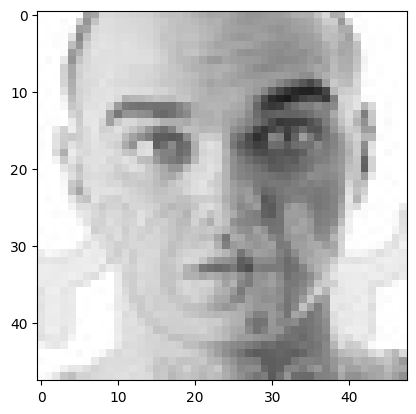

In [74]:
import random

# Get list of subfolders in train_dir
subfolders = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, train_dir, f)) or os.path.isdir(os.path.join(train_dir, f))]
if not subfolders:
    subfolders = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]

print(f"Number of classes: {len(subfolders)}")
print("Class names:", subfolders)

# Pick a random subfolder
random_subfolder = random.choice(subfolders)
subfolder_path = os.path.join(train_dir, random_subfolder)

# Get a random image file from the subfolder
image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_image = random.choice(image_files)
image_path = os.path.join(subfolder_path, random_image)

# Read and show the shape of the image
img = cv2.imread(image_path)

print("Total images:", len(image_files))
print(f"Random subfolder: {random_subfolder}")
print(f"Random image: {random_image}")
print(f"Image shape: {img.shape}")
print(f"Image shape: {img.size}")
print(f"Image shape: {img.ndim}")
plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

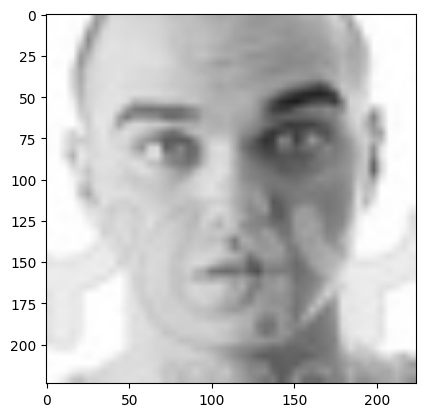

In [75]:
img_size = 224
new_array = cv2.resize(img, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))

In [76]:
traing_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_size, img_size),
    batch_size=16,
    shuffle=True,
    interpolation='bilinear', # Smooth average
)	

Found 28709 files belonging to 7 classes.


In [77]:
test_dir = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_size, img_size),
    batch_size=16,
    shuffle=True,
    interpolation='bilinear', # Smooth average
)	

Found 7178 files belonging to 7 classes.


In [78]:
base_model = tf.keras.applications.MobileNetV2()

In [79]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Transfer Learning - Tuning, Weights will start from the last check point

In [80]:
# Extract the input and output layers from the pretrained model
# We will use the second to last layer as the output for our custom model
base_input = base_model.layers[0].input
base_output = base_model.layers[-2].output
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_3')>

In [81]:
myoutputlayer = tf.keras.layers.Dense(128, activation='relu')(base_output) # adding a dense layer after the base model output
#myoutputlayer = tf.keras.layers.Dropout(0.2)(myoutputlayer) # adding dropout to prevent overfitting
myoutputlayer = tf.keras.layers.Dense(64, activation='relu')(myoutputlayer) # adding another dense layer
myoutputlayer = tf.keras.layers.Dense(len(subfolders), activation='softmax')(myoutputlayer) # this my classification layer, the number of classes is equal to the number of subfolders
myoutputlayer

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_20')>

In [82]:
mymodel = tf.keras.Model(inputs=base_input, outputs=myoutputlayer)
mymodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [83]:
mymodel.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [92]:
traing_history = mymodel.fit(
    traing_data,
    epochs=10,
    validation_data=test_dir,
    validation_steps=10,
    verbose=1
)

Epoch 1/10


1795/1795 [==============================] - 234s 130ms/step - loss: 0.2382 - accuracy: 0.9165 - val_loss: 2.2595 - val_accuracy: 0.5375
Epoch 2/10
1795/1795 [==============================] - 231s 129ms/step - loss: 0.2311 - accuracy: 0.9180 - val_loss: 1.9799 - val_accuracy: 0.6062
Epoch 3/10
1795/1795 [==============================] - 232s 129ms/step - loss: 0.2169 - accuracy: 0.9219 - val_loss: 2.3539 - val_accuracy: 0.5938
Epoch 4/10
1795/1795 [==============================] - 232s 129ms/step - loss: 0.2040 - accuracy: 0.9284 - val_loss: 1.8803 - val_accuracy: 0.5938
Epoch 5/10
1795/1795 [==============================] - 232s 129ms/step - loss: 0.2016 - accuracy: 0.9294 - val_loss: 2.0839 - val_accuracy: 0.6250
Epoch 6/10
1795/1795 [==============================] - 234s 130ms/step - loss: 0.1973 - accuracy: 0.9308 - val_loss: 2.6753 - val_accuracy: 0.5500
Epoch 7/10
1795/1795 [==============================] - 234s 130ms/step - loss: 0.1861 - accuracy: 0.9341 - val_loss: 2.764

In [ ]:
### Saving the model and testing models
mymodel.save(r'D:\Project10_face_emontion_recognition\my_model.keras')
mymodel.evaluate(test_dir)

449/449 [==============================] - 20s 44ms/step - loss: 1.8043 - accuracy: 0.6158


[1.8043118715286255, 0.6157703995704651]

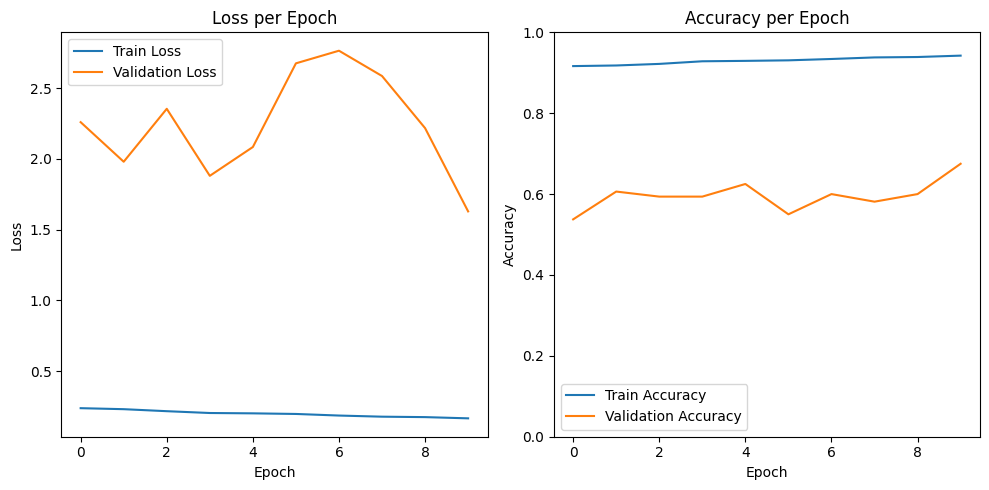

In [101]:
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(traing_history.history['loss'], label='Train Loss')
plt.plot(traing_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')

plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(traing_history.history['accuracy'], label='Train Accuracy')
plt.plot(traing_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()



### Preparing To Test

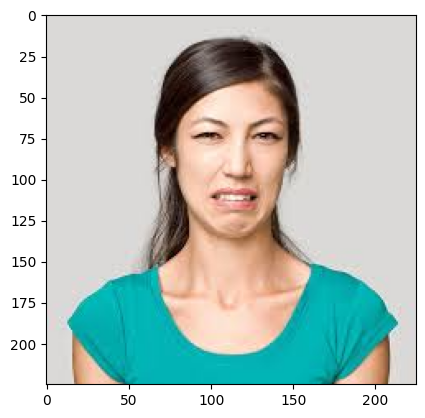

In [113]:
#test_frame = cv2.imread(r'D:\Project10_face_emontion_recognition\happy.jpg')
#test_frame = cv2.imread(r'D:\Project10_face_emontion_recognition\discust.jpg')
test_frame = cv2.imread(r'D:\Project10_face_emontion_recognition\disgust.jpg')
#test_frame = cv2.imread(r'D:\Project10_face_emontion_recognition\test_angry.jpg')
test_frame.shape
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))

In [114]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cvt_gray = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)
cvt_gray.shape

(225, 225)

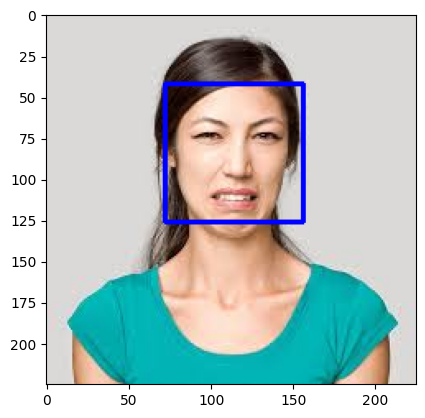

In [118]:
face_detect = face_cascade.detectMultiScale(cvt_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
for x, y, w, h in face_detect:
    cv2.rectangle(test_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))

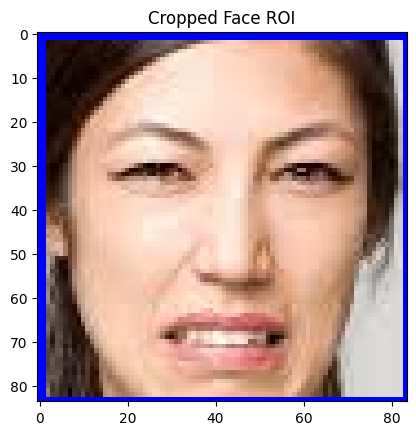

In [119]:
# Crop the face region of interest (ROI) from test_frame using the detected face coordinates
if len(face_detect) > 0:
    x, y, w, h = face_detect[0]
    face_roi = test_frame[y:y+h, x:x+w]
    plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Face ROI")
    #plt.axis('off')
    plt.show()
else:
    print("No face detected.")

### Prediction with model

In [126]:
resized_face = cv2.resize(face_roi, (img_size, img_size))
resized_face = np.expand_dims(resized_face, axis=0)  # Add batch dimension
resized_face = resized_face / 255.0  # Normalize the image
predictions = mymodel.predict(resized_face)
predictions[0] # This will give you the probabilities for each class

1/1 [==============================] - 0s 30ms/step


array([0.5953865 , 0.00731181, 0.05911732, 0.05817868, 0.19240552,
       0.07432084, 0.01327933], dtype=float32)

In [127]:
# Get the predicted class index and corresponding label name
predicted_class_idx = np.argmax(predictions[0])
predicted_label = subfolders[predicted_class_idx]
print(f"Predicted class index: {predicted_class_idx}")
print(f"Predicted label: {predicted_label}")

Predicted class index: 0
Predicted label: angry
